# vote_coefficients-0xdf22a2C8F6BA9376fF17EE13E6154B784ee92094


In [1]:
import os
from pathlib import Path
import numpy as np

import pandas as pd

from sbdata.FlipsideApi import FlipsideApi

# Set path to data folder
current_dir = Path(os.getcwd())
PATH_TO_EXPORT = os.path.join(current_dir.parent.parent, 'tx_data', 'all_beta_rounds')
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')
DATA_DIR_GITCOIN = os.path.join(current_dir.parent.parent, 'data-gitcoin')
CSV_GITCOIN_GRANTS = 'vote_coefficients-0xdf22a2C8F6BA9376fF17EE13E6154B784ee92094.csv'

# read the address from oss grant

api_key = os.environ['FLIPSIDE_API_KEY']
flipside_api = FlipsideApi(api_key, max_address=400)
PATH_TO_VOTES = os.path.join(DATA_DIR, "votes_baoki.csv")
PATH_TO_GRANTS = os.path.join(DATA_DIR, "all-allo-rounds.csv")
PATH_TO_PROJECTS = os.path.join(DATA_DIR, "projects_QmQurt.csv")
PATH_TO_VOTES_GITCOIN = os.path.join(DATA_DIR_GITCOIN, CSV_GITCOIN_GRANTS)

# load data
df_votes = pd.read_csv(PATH_TO_VOTES_GITCOIN)
df_grants = pd.read_csv(PATH_TO_GRANTS)
df_application = pd.read_csv(PATH_TO_PROJECTS)
# Lowercase all addresses because flipside api return lowercase address
#id,projectId,applicationId,roundId,token,voter,grantAddress,amount,amountUSD,coefficient,status,last_score_timestamp,type,success,rawScore,threshold
df_grants['Round ID'] = df_grants['Round ID'].str.lower()
str_columns_votes = ['id', 'projectId', 'roundId', 'voter', 'grantAddress']
df_votes[str_columns_votes] = df_votes[str_columns_votes].applymap(lambda x: x.lower())

str_columns_application = ['id', 'roundId', 'metadata.application.round', 'metadata.application.recipient']
df_application[str_columns_application] = df_application[str_columns_application].applymap(lambda x: str(x).lower())

# round_id = df_grants[df_grants['Round name'] == 'Web3 Community and Education']['Round ID'].values[0]
array_unique_address = df_votes['voter'].unique()

array_unique_address = np.char.lower(array_unique_address.astype(str))


In [2]:
from sbutils import LoadData

# Load data
data_loader = LoadData.LoadData(PATH_TO_EXPORT)
df_tx = data_loader.create_df_tx('ethereum', array_unique_address)

In [3]:
len(array_unique_address)

1062

In [4]:
df_tx.EOA.nunique()

1062

In [5]:
c = np.setxor1d(array_unique_address, df_tx.EOA.values)
c

array([], dtype=object)

## Computing legos booleans

In [6]:
from sblegos.TransactionAnalyser import TransactionAnalyser as txa
tx_analyser = txa(df_tx, df_address=pd.DataFrame(np.intersect1d(df_tx.EOA.unique(), array_unique_address)))

use matching address because some addresses are not in the extracted data set

In [7]:
df_matching_address = pd.DataFrame(df_tx.EOA.unique(), columns=["address"])
df_matching_address.head(2)

,address
0,0x0000005178d55139ba21423218ea7290a7ccdc81
1,0x0029ab135b5be72168bf80f140d60a9264dbd0c5


Compute the boolean 

less than 10 x transaction are not performant legos so we don't use it, has same seed is computed as an intermediarry to get the seed_suspicious flag

In [8]:
df_matching_address['seed_same_naive'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed_naive(x))
df_matching_address['seed_same'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed(x))
df_matching_address['seed_suspicious'] = df_matching_address.loc[:, 'seed_same_naive'].ne(df_matching_address.loc[:, 'seed_same'])
df_matching_address['less_5_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 5))
# df_matching_address['less_10_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 10))
df_matching_address['interacted_other_ctbt'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_interacted_with_other_contributor(x))

In [9]:
print(f'Number of voters: {len(df_matching_address)}')

Number of voters: 1062


In [10]:
df_matching_address.sum()

address                  0x0000005178d55139ba21423218ea7290a7ccdc810x00...
seed_same_naive                                                        604
seed_same                                                              630
seed_suspicious                                                         26
less_5_tx                                                                4
interacted_other_ctbt                                                  165
dtype: object

### Investigating the boolean seed suspicious

In [11]:
df_matching_address[df_matching_address['seed_suspicious'] == True]

,address,seed_same_naive,seed_same,seed_suspicious,less_5_tx,interacted_other_ctbt
18,0x059fde12f424fa2aa9c3d9fd128cbe47b9bc2a85,False,True,True,False,False
47,0x0b02898ad0b7e19e3ebea23c74eafafe6a867dda,False,True,True,False,False
59,0x0e75eabd04986a8fb0b8cb30d6dd069c86e5e142,False,True,True,False,False
157,0x274b15188071778ee870c6b9462f07d7456a81de,False,True,True,False,False
202,0x31fe409c0d66af66a40b21a1c963168f4e1323b3,False,True,True,False,False
270,0x4189ab08f226612a0181642b63f55fc2e6fa0537,False,True,True,False,False
278,0x4360187ba1204bf91e9f697f67283b38f962da3e,False,True,True,False,False
293,0x47a39544dc1af6ab7060babde4a336a795e652d3,False,True,True,False,False
316,0x4e441d3a31c8b2672a7685482bd288938e5b7833,False,True,True,False,False
367,0x5aeedbc6b655c13950f32e5e8a0760d15bbe0afb,False,True,True,False,False


In [12]:
# projects_voted = df_votes[df_votes['voter'] == '0xc28064b875ae25f9a2ca28c08f116a5c26229f69']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'status', 'metadata.application.round']].reset_index(drop=True)

Some of the projects he donated to are in the list of Rejected projects showing that this address is indeed a sybil. And may have contributed to ohter fraudulent projects.

- Pulsar is not very active and is forked code for the most part
- Fusion not very active on github but has a lot of activity on twitter 
- Share suspicious Github with no activity, twitter does not exists: suspicious

Other projects are ok

In [13]:
# projects_voted = df_votes[df_votes['voter'] == '0x61ffe691821291d02e9ba5d33098adcee71a3a17']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title']].reset_index(drop=True)

In [14]:
# projects_voted = df_votes[df_votes['voter'] == '0xe51200a4d161935fc311ed8a0401feb1abf20e3a']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title']].reset_index(drop=True)

The boolean seed suspicious is not relevant for that round we will not use it for the analysis.

### Computing the new dex interaction score
It was investigated in another notebook 

In [15]:
def get_interacted_address(from_address, to_address, address):
    if from_address == address:
        return to_address
    else:
        return from_address

def count_interaction_with_any(tx_analyser, address, array_address):
    """
    Return an integer of the number of interactions with the addresses in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    count_interaction_with_any : int
        The number of interactions with the addresses in the array_address
    """
    tx_analyser.set_group_by_sorted_EOA()

    df = tx_analyser.gb_EOA_sorted.get_group(address)
    address_interacted = df.apply(lambda x: get_interacted_address(x['from_address'], x['to_address'], address), axis=1)
    tx_boolean_interacted = address_interacted.isin(array_address)
    return tx_boolean_interacted.sum()

def has_interacted_with_any(tx_analyser, address, array_address):
    """
    Return a boolean whether the address has interacted with any address in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    has_interacted_with_any : bool
        True if the address has interacted with one or more of the addresses in the array_address
    """
    count_interaction_with_any = count_interaction_with_any(tx_analyser, address, array_address)
    return count_interaction_with_any > 0

In [16]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'pool' 
;'''
df_label = flipside_api.execute_query(label_query)

In [17]:
# extract all the pool addresses
array_pool_address = df_label['address'].unique()

In [18]:
tx_analyser.set_group_by_sorted_EOA()

In [19]:
# Compute the number of interactions with any of the pools for each address
df_matching_address['count_interaction_with_pool'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, array_pool_address))

In [20]:
(df_matching_address['count_interaction_with_pool'] > 0).sum() / len(df_matching_address)

0.507532956685499

In [21]:
label_query = '''
SELECT DISTINCT(LABEL_SUBTYPE)
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
;'''
df_distinct_labels = flipside_api.execute_query(label_query)

In [22]:
df_distinct_labels.label_subtype.unique()

array(['chadmin', 'aggregator_contract', 'multisig', 'airdrop_contract',
       'foundation', 'marketplace', 'treasury', 'token_sale', 'voting',
       'swap_contract', 'strategy', 'hot_wallet', 'contract_deployer',
       'donation_address', 'mining_pool', 'governance', 'oracle', 'toxic',
       'dao', 'rewards', 'deposit_wallet', 'staking_contract', 'vault',
       'reserve', 'escrow', 'nf_token_contract', 'token_distribution',
       'nf_position_manager', 'general_contract', 'distributor_cex',
       'swap_router', 'router', 'token_contract', 'bridge', 'mint_burn',
       'mint_contract', 'cold_wallet', 'pool', 'fee_wallet'], dtype=object)

From these tags lets flag any address that have interacted with a toxic wallet

In [23]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'toxic'
;'''
df_toxic = flipside_api.execute_query(label_query)

In [24]:
df_toxic.shape

(4857, 6)

In [25]:
# Compute the number of interactions with any of the scam for each address
df_matching_address['count_interaction_with_toxic'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_toxic['address'].unique()))

In [26]:
print(f'Percentage of addresses that have interacted with a toxic address: {int((df_matching_address["count_interaction_with_toxic"] > 0).sum() / len(df_matching_address) *100)}%')

Percentage of addresses that have interacted with a toxic address: 2%


In [27]:
tag_query = '''
SELECT DISTINCT(TAG_TYPE)
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
;'''
df_distinct_tags = flipside_api.execute_query(tag_query)

In [28]:
df_distinct_tags.tag_type.values

array(['activity', 'Aave Delegates', 'dex', 'wallet', 'contract', 'NFT',
       'dydx delegate', 'nft', 'cex', 'Balancer Delegates',
       'chainlink oracle'], dtype=object)

I found the tag_name "airdrop master" could be interesting 

In [29]:
query_airdrop_master = '''
SELECT BLOCKCHAIN, CREATOR, ADDRESS, TAG_NAME
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
AND TAG_NAME = 'airdrop master'
;
'''
df_airdrop_master = flipside_api.execute_query(query_airdrop_master)

In [30]:
# Compute the number of interactions with any of the aidrop for each address
df_matching_address['count_interaction_with_airdrop_m'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_airdrop_master['address'].unique()))
print(f'Percentage of addresses that interacted with airdrop master: {int((df_matching_address["count_interaction_with_airdrop_m"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with airdrop master: 25%


In [31]:
# Boolean whether the address is a aidrop master
df_matching_address['is_airdrop_master'] = df_matching_address['address'].apply(lambda x: x in df_airdrop_master['address'].unique()) 
print(f'Percentage of addresses that are airdrop master: {int((df_matching_address["is_airdrop_master"]).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that are airdrop master: 12%


In [32]:
sql_query_tornado = '''
SELECT DISTINCT PROJECT_NAME, ADDRESS
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND PROJECT_NAME LIKE '%tornado%'
;
'''
df_tornado = flipside_api.execute_query(sql_query_tornado)

In [33]:
# Count the number of interactions with tornado
df_matching_address['count_interaction_with_tornado'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_tornado['address'].unique()))
print(f'Percentage of addresses that interacted with tornado: {int((df_matching_address["count_interaction_with_tornado"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with tornado: 4%


In [34]:
# Count the number of time the address interatec with disperse contract: '0xD152f549545093347A162Dce210e7293f1452150'
df_matching_address['count_interaction_with_disperse'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, [str.lower('0xD152f549545093347A162Dce210e7293f1452150')]))
print(f'Percentage of addresses that interacted with disperse: {int((df_matching_address["count_interaction_with_disperse"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with disperse: 2%


In [35]:
df_matching_address.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,count_interaction_with_pool,count_interaction_with_toxic,count_interaction_with_airdrop_m,count_interaction_with_tornado,count_interaction_with_disperse
count,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000
mean,13.700565,0.051789,3.919962,0.316384,0.159134
std,91.830114,0.378687,16.151503,2.568514,1.737784
min,0.000000,0.000000,0.000000,0.000000,0.000000
10%,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,0.000000,1.000000,0.000000,0.000000
90%,22.000000,0.000000,7.000000,0.000000,0.000000
max,2632.000000,7.000000,208.000000,55.000000,39.000000


In [36]:
df_matching_address['has_interaction_toxic'] = df_matching_address['count_interaction_with_toxic'] > 0
df_matching_address['has_no_pool_interaction'] = df_matching_address['count_interaction_with_pool'] < 6
df_matching_address['has_interaction_airdrop_m'] = df_matching_address['count_interaction_with_airdrop_m'] > 0
df_matching_address['has_interaction_tornado'] = df_matching_address['count_interaction_with_tornado'] > 0
df_matching_address['has_interaction_disperse'] = df_matching_address['count_interaction_with_disperse'] > 0

In [37]:
boolean_features = ['seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_airdrop_m', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'interacted_other_ctbt']

In [38]:
df_matching_address[boolean_features].sum() 

seed_suspicious               26
has_interaction_toxic         31
has_no_pool_interaction      803
has_interaction_airdrop_m    270
has_interaction_tornado       43
has_interaction_disperse      26
is_airdrop_master            136
interacted_other_ctbt        165
dtype: int64

In [39]:
len(df_matching_address)

1062

In [40]:
(df_matching_address[boolean_features].sum(axis=1) > 2).sum()

115

In [41]:
df_matching_address['count_flags'] = df_matching_address[boolean_features].sum(axis=1)

In [42]:
df_matching_address['suspicious_1'] = df_matching_address['count_flags'] > 2

In [43]:
df_suspicious_1 = df_matching_address[df_matching_address['suspicious_1'] == True]

### Investigating the grants receiving the most votes from the flagged addresses

In [44]:
df_vote_sus1 = df_votes[df_votes['voter'].isin(df_suspicious_1['address'])]
count_unique_vote_grant = df_votes.drop_duplicates(subset=['grantAddress', 'voter']).groupby('grantAddress')['id'].count().sort_values(ascending=False).reset_index()
count_suspicious_vote_grant = df_vote_sus1['grantAddress'].value_counts().reset_index()
df_vote_grant = count_unique_vote_grant.merge(count_suspicious_vote_grant, left_on='grantAddress', right_on='grantAddress', how='left').fillna(0).rename(columns={'id': 'count_unique_vote', 'count': 'count_suspicious_vote'})

In [45]:
df_vote_grant['percentage_suspicious_vote'] = df_vote_grant['count_suspicious_vote'] / df_vote_grant['count_unique_vote'] * 100
print(f'Number of suspicious votes {df_vote_sus1.shape[0]} Number of projects voted: {df_vote_sus1.grantAddress.nunique()}')
# Merge the project the user voted for and the projects 
gr_sus = df_vote_grant.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'percentage_suspicious_vote', 'count_suspicious_vote', 'roundId', 'status']].reset_index(drop=True).sort_values(by='percentage_suspicious_vote', ascending=False)
print(f'number of grants: {gr_sus.shape[0]}')
gr_sus.head(30)

Number of suspicious votes 464 Number of projects voted: 23
number of grants: 25


,grantAddress,metadata.application.project.title,percentage_suspicious_vote,count_suspicious_vote,roundId,status
17,0x242ba6d68ffeb4a098b591b32d370f973ff882b7,"Blockscout - Decentralized, Open-source Block ...",18.867925,20.0,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
15,0x4557b18e779944bfe9d78a672452331c186a9f48,wagmi,17.500000,21.0,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
9,0xfcc41c4614bd464ba28ad96f93aadaa7ba6c8680,clr.fund,16.763006,29.0,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,REJECTED
10,0x8ba1f109551bd432803012645ac136ddd64dba72,ethers.js,14.792899,25.0,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
8,0xb7081fd06e7039d198d10a8b72b824e60c1b1e16,Otterscan,14.525140,26.0,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
5,0x53390590476dc98860316e4b46bb9842af55efc4,DAppNode,13.537118,31.0,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
14,0xc8f9f8c913d6ff031c65e3bf7c7a51ad1f3a86e5,Lodestar,12.213740,16.0,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
6,0xf29ff96aaea6c9a1fba851f74737f3c069d4f1a9,Protocol Guild,12.149533,26.0,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
4,0xd165df4296c85e780509fa1eace0150d945d49fd,EthStaker,11.522634,28.0,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
20,0x6e41fe2f8303b89c9dbccabe59a7f7f8f4312ca9,Stereum - Ethereum Node Installer & Manager,11.235955,10.0,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED


### Look at the addresses with at least one flag

We are going to review the addresses that have at least 1 flag:
- has_intercation_toxic 
- has_interaction_disperse
- has_interaction_airdrop_master
- is airdrop master
- seed suspicious
- interacted with other contributor and less than 5 tx

I decided to remove tornado cash because someone can be anonimous with out being a sybil

In [46]:
df_matching_address['interact_less_5tx'] = np.logical_and(df_matching_address['interacted_other_ctbt'], df_matching_address['less_5_tx'])

In [47]:
interaction_bool = ['has_interaction_toxic', 'has_interaction_airdrop_m', 'has_interaction_disperse', 'is_airdrop_master', 'seed_suspicious', 'interact_less_5tx']

In [48]:
df_matching_address[interaction_bool].sum()

has_interaction_toxic         31
has_interaction_airdrop_m    270
has_interaction_disperse      26
is_airdrop_master            136
seed_suspicious               26
interact_less_5tx              0
dtype: int64

In [49]:
from scipy.spatial.distance import pdist

def jaccard_similarity_matrix(df):
    
    n = df.shape[1]
    scores = 1 - pdist(np.array(df).T, metric='jaccard')
    result = np.zeros((n,n))
    result[np.triu_indices(n, k=1)] = scores
    result += result.T
    np.fill_diagonal(result, 1)
    return pd.DataFrame(result, index=df.columns, columns=df.columns)

jaccard_similarity = jaccard_similarity_matrix(df_matching_address[interaction_bool])
jaccard_similarity

,has_interaction_toxic,has_interaction_airdrop_m,has_interaction_disperse,is_airdrop_master,seed_suspicious,interact_less_5tx
has_interaction_toxic,1.000000,0.082734,0.117647,0.084416,0.000000,0.0
has_interaction_airdrop_m,0.082734,1.000000,0.068592,0.409722,0.013699,0.0
has_interaction_disperse,0.117647,0.068592,1.000000,0.072848,0.040000,0.0
is_airdrop_master,0.084416,0.409722,0.072848,1.000000,0.012500,0.0
seed_suspicious,0.000000,0.013699,0.040000,0.012500,1.000000,0.0
interact_less_5tx,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


<Axes: >

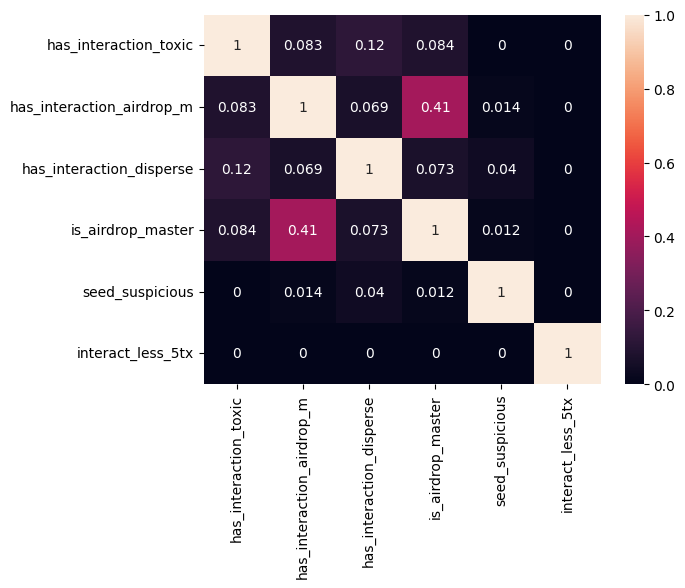

In [50]:
import seaborn as sns
sns.heatmap(jaccard_similarity, annot=True)

In [52]:
df_matching_address['flagged'] = df_matching_address[interaction_bool].sum(axis=1) > 0
df_interact_sus_2 = df_matching_address[df_matching_address['flagged'] == True]
print(f'Number of addresses that interacted with a suspicious contract or address: {df_interact_sus_2.shape[0]}')

Number of addresses that interacted with a suspicious contract or address: 323


In [53]:
df_vote_sus_2 = df_votes[df_votes['voter'].isin(df_interact_sus_2['address'])]
# count_unique_vote_grant = df_votes.drop_duplicates(subset=['grantAddress', 'voter']).groupby('grantAddress')['id'].count().sort_values(ascending=False).reset_index().head(10)
count_suspicious_vote_grant_2 = df_vote_sus_2['grantAddress'].value_counts().reset_index()
df_vote_grant_2 = count_unique_vote_grant.merge(count_suspicious_vote_grant_2, left_on='grantAddress', right_on='grantAddress', how='left').fillna(0).rename(columns={'id': 'count_unique_vote', 'count': 'count_suspicious_vote'})

In [54]:
df_vote_grant_2['percentage_suspicious_vote'] = df_vote_grant_2['count_suspicious_vote'] / df_vote_grant_2['count_unique_vote'] * 100
print(f'Number of suspicious votes {df_vote_sus_2.shape[0]} Number of projects voted: {df_vote_sus_2.grantAddress.nunique()}')
# Merge the project the user voted for and the projects 
gr_sus_2 = df_vote_grant_2.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'percentage_suspicious_vote', 'count_suspicious_vote', 'roundId', 'status']].reset_index(drop=True).sort_values(by='percentage_suspicious_vote', ascending=False)
print(f'number of grants: {gr_sus.shape[0]}')
gr_sus_2.head(30)

Number of suspicious votes 1274 Number of projects voted: 25
number of grants: 25


,grantAddress,metadata.application.project.title,percentage_suspicious_vote,count_suspicious_vote,roundId,status
24,0xfc756d8632a19cebd76560ce0a6967279e32131b,Prettier Solidity,66.666667,4,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
23,0xe02aae2cc50763b22e268593237ef822339853cf,Dapplet,50.000000,7,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
17,0x242ba6d68ffeb4a098b591b32d370f973ff882b7,"Blockscout - Decentralized, Open-source Block ...",44.339623,47,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
9,0xfcc41c4614bd464ba28ad96f93aadaa7ba6c8680,clr.fund,39.884393,69,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,REJECTED
20,0x6e41fe2f8303b89c9dbccabe59a7f7f8f4312ca9,Stereum - Ethereum Node Installer & Manager,39.325843,35,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
15,0x4557b18e779944bfe9d78a672452331c186a9f48,wagmi,39.166667,47,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
21,0x8d3809951c7f1d18227251b0cb047735dbf8f8fc,Ephemery Testnet,37.837838,14,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
10,0x8ba1f109551bd432803012645ac136ddd64dba72,ethers.js,35.502959,60,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
6,0xf29ff96aaea6c9a1fba851f74737f3c069d4f1a9,Protocol Guild,35.046729,75,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED
14,0xc8f9f8c913d6ff031c65e3bf7c7a51ad1f3a86e5,Lodestar,34.351145,45,0xdf22a2c8f6ba9376ff17ee13e6154b784ee92094,APPROVED


In [55]:
boolean_to_keep = ['seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'has_interaction_airdrop_m', 'interacted_other_ctbt', 'interact_less_5tx', 'flagged']

In [56]:
df_matching_address[boolean_to_keep].sum()

seed_suspicious               26
has_interaction_toxic         31
has_no_pool_interaction      803
has_interaction_tornado       43
has_interaction_disperse      26
is_airdrop_master            136
has_interaction_airdrop_m    270
interacted_other_ctbt        165
interact_less_5tx              0
flagged                      323
dtype: int64

In [71]:
final_merge = df_votes.merge(df_matching_address[['address'] + boolean_to_keep], left_on='voter', right_on='address', how='left')
print(f'number of squelched votes out of {final_merge.shape[0]}')
final_merge.shape[0] - final_merge[['coefficient']].sum() 

number of squelched votes out of 4307


coefficient    350
dtype: int64

In [63]:
print(df_votes.shape)
print(final_merge.shape)

(4307, 16)
(4307, 27)


C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_15708\2681738413.py:7: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))


(81811, 19) votes stephi
(4307, 27) final merge
(4307, 29) votes merge


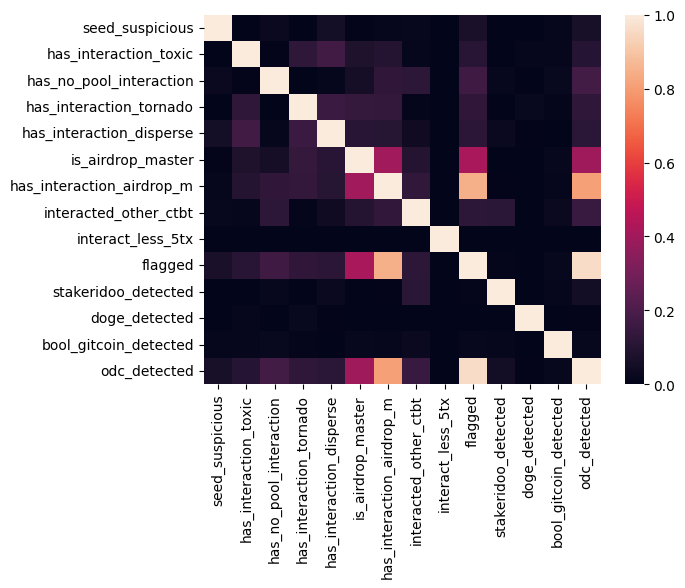

In [75]:
# Adding Stakeriddo and Gray flagged wallet

DATA_DIR_STEFI = os.path.join(current_dir.parent.parent, 'stefi')
CSV_STEPHI = 'sso_odc_analysis.csv'

# load data
df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))
print(f'{df_votes_stephi.shape} votes stephi')
print(f'{final_merge.shape} final merge')
df_stephi_bool_voter = df_votes_stephi[['voter', 'stakeridoo_detected', 'doge_detected']]
df_merge = final_merge.merge(df_stephi_bool_voter.drop_duplicates(subset=['voter']), left_on='voter', right_on='voter', how='left')
print(f'{df_merge.shape} votes merge')

df_merge['bool_gitcoin_detected'] = np.logical_not(df_merge.success.astype(bool))
df_merge['stakeridoo_detected'].fillna(False, inplace=True)
df_merge['doge_detected'].fillna(False, inplace=True)
df_merge['odc_detected'] = np.logical_or(np.logical_or(df_merge['stakeridoo_detected'], df_merge['doge_detected']), df_merge['flagged'])

boolean_jaccard = boolean_to_keep + ['stakeridoo_detected', 'doge_detected', 'bool_gitcoin_detected', 'odc_detected']
jaccard_similarity_2 = jaccard_similarity_matrix(df_merge[boolean_jaccard])
sns.heatmap(jaccard_similarity_2)

df_merge['proposed_coeff'] = np.logical_not(np.logical_or(df_merge['odc_detected'], df_merge['bool_gitcoin_detected']))

df_merge.drop(columns=['bool_gitcoin_detected', 'address']).to_csv(f'../output_gitcoin/n_{CSV_GITCOIN_GRANTS}', index=False)

In [80]:
df_merge[boolean_jaccard].sum(axis=0)

seed_suspicious                87
has_interaction_toxic         135
has_no_pool_interaction      3190
has_interaction_tornado       245
has_interaction_disperse      148
is_airdrop_master             530
has_interaction_airdrop_m    1076
interacted_other_ctbt         539
interact_less_5tx               0
flagged                      1274
stakeridoo_detected            64
doge_detected                   7
bool_gitcoin_detected          85
odc_detected                 1331
dtype: int64